Goal of debugging deconvolution:
1. Replace the quadratic programming function with osqp.
2. Penalize large estimated probability differences between samples with the same age.
3. Use absolute loss instead of quadratic loss.

In [1]:
import pandas as pd
import numpy as np
from utils.misc import extract_number
from utils.deconvolution import predict_l2, predict_l1, loo_predict

In [2]:
# load data
gene_expressions = pd.read_csv("data/train_data.csv", index_col=0)
gene_expressions_mat = gene_expressions.to_numpy()
genenames = np.array(gene_expressions.index.tolist())
samples = gene_expressions.columns.tolist()

# extract ages
ages = np.array([extract_number(timestring) for timestring in samples])
unique_ages=np.unique(ages)

# retain genes that are present in all samples
prevalence = np.mean(gene_expressions_mat > 0, axis=1)
subset_gene_id = np.where(prevalence == 1)[0]
subset_genenames = genenames[subset_gene_id]
gene_expressions = gene_expressions.loc[subset_genenames, :]
gene_expressions_mat = gene_expressions_mat[subset_gene_id, :]

# get log expressions
log_gene_expressions = np.log(gene_expressions)
log_gene_expressions_mat = np.log(gene_expressions_mat)

# transpose count tables to samples by genes
gene_expressions = gene_expressions.T
gene_expressions_mat = gene_expressions_mat.T
log_gene_expressions = log_gene_expressions.T
log_gene_expressions_mat = log_gene_expressions_mat.T

# get rankings of samples for each gene expression
gene_expressions_rank = log_gene_expressions.rank()

In [3]:
gene_rankings = pd.read_excel("data/variation_order.xlsx", sheet_name="4_23", index_col=0)
top_genes = gene_rankings.index[:200]

In [4]:
gene_expressions_subset = gene_expressions.loc[ages <= 23, top_genes]
ages_subset = ages[ages <= 23]
unique_ages = np.unique(ages_subset)

In [5]:
unique_ages

array([ 2,  4,  6,  8, 10, 12, 13, 15, 17, 18, 21, 23])

In [6]:
predictions_0, prob_mat_0 = loo_predict(expression_df=gene_expressions_subset,
                                    labels=ages_subset, penalty=0)
predictions_1, prob_mat_1 = loo_predict(expression_df=gene_expressions_subset,
                                    labels=ages_subset, penalty=0.1)
predictions_2, prob_mat_2 = loo_predict(expression_df=gene_expressions_subset,
                                    labels=ages_subset, penalty=0.2)
predictions_3, prob_mat_3 = loo_predict(expression_df=gene_expressions_subset,
                                    labels=ages_subset, penalty=0.3)
predictions_4, prob_mat_4 = loo_predict(expression_df=gene_expressions_subset,
                                    labels=ages_subset, penalty=0.4)

Visualize the fitted weights.

In [7]:
colors = ["#808080", "#db382c", "#2f7028", "#665223", "#344885"]
x_values = np.arange(1, len(ages_subset))
x_values_mat = np.tile(x_values, (5, 1))

In [15]:
true_age = ages_subset[20]
weights = np.concatenate((prob_mat_0[:, 20].reshape(1, -1),
                        prob_mat_1[:, 20].reshape(1, -1),
                        prob_mat_2[:, 20].reshape(1, -1),
                        prob_mat_3[:, 20].reshape(1, -1),
                        prob_mat_4[:, 20].reshape(1, -1)),
                       axis=0)

weights = np.delete(weights, 20, axis=1)

predicted_ages = [predictions_0["Predicted"][20], predictions_1["Predicted"][20],
                  predictions_2["Predicted"][20], predictions_3["Predicted"][20],
                  predictions_4["Predicted"][20]]

color_maps = {f"alpha={0.1*j:.1f}|Mean={predicted_ages[j]:.2f}": colors[j] for j in range(5)}

train_ages = np.delete(ages_subset, 20)
ids_identical = np.where(train_ages == true_age)[0]
correct_regions = [np.min(ids_identical)+1-0.5, np.max(ids_identical)+1+0.5]
xticks = np.zeros(len(unique_ages))

for index, unique_age in enumerate(unique_ages):
    ids = np.where(train_ages == unique_age)[0]
    xticks[index] = np.min(ids)+1

xnames = unique_ages.astype(str)

title = f"True Age: {true_age}"

In [13]:
from utils.viz import single_line_plot

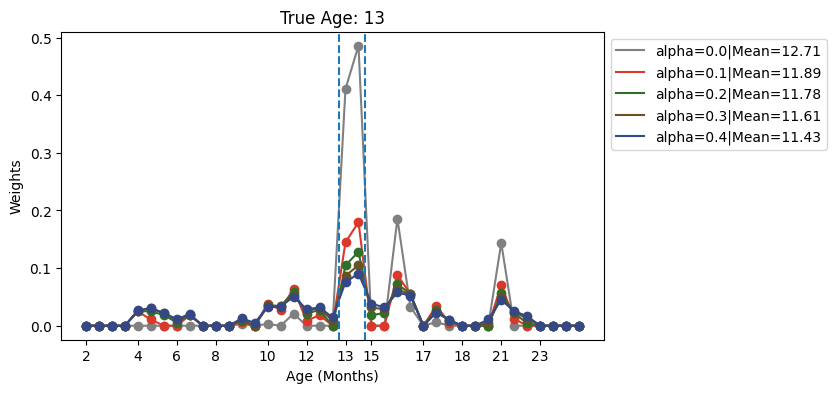

In [17]:
fig = single_line_plot(ymat=weights, xmat=x_values_mat, colors=colors,
                       xticks=xticks, xticknames=xnames, xname="Age (Months)",
                       yname="Weight",
                       vertical_lines=correct_regions, colors_map=color_maps,
                       title=title, size=(7,4))